In [1]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error

/Users/deepakdeokar/Desktop/GDP_Forecasting_Project/venv4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# Step 2: Load the Cleaned Dataset
data_path = "../data/worldbank_gdp_cleaned.csv"

if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset not found at {data_path}. Please run the EDA notebook first.")

# Load the dataset
df = pd.read_csv(data_path)

In [3]:
# Step 3: Function to Train and Forecast using Prophet

def train_prophet(country_name, forecast_years=5, split_year=2015):
    """
    Train a Facebook Prophet model for a given country and forecast future GDP growth rate.
    
    Args:
    country_name (str): Name of the country.
    forecast_years (int): Number of years to forecast.

    Returns:
    - model: fitted Prophet model
    - forecast_df: forecasted DataFrame
    - full_df: original + forecasted data
    """
    # Filter data
    country_df = df[df['country'] == country_name].sort_values('Year')
    if country_df.empty:
        raise ValueError(f"No data found for country: {country_name}")

    # Prepare for Prophet: Prophet requires columns: ds (date) and y (target)
    prophet_df = country_df[['Year', 'GDP Growth Rate (%)']].rename(columns={'Year': 'ds', 'GDP Growth Rate (%)': 'y'})
    prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y')

    # Split into train and test
    train_df = prophet_df[prophet_df['ds'].dt.year <= split_year]
    test_df = prophet_df[prophet_df['ds'].dt.year > split_year]

    # Fit model
    model = Prophet()
    model.fit(train_df)

    # Create future dataframe
    future = model.make_future_dataframe(periods=len(test_df), freq='Y')

    # Forecast
    forecast_df = model.predict(future)

    # Extract forecasted values corresponding to test years
    forecast_test = forecast_df.tail(len(test_df))['yhat'].values

    # Evaluation
    y_true = test_df['y'].values
    rmse = np.sqrt(mean_squared_error(y_true, forecast_test))
    mae = mean_absolute_error(y_true, forecast_test)

    # Combine full years for plotting
    historical_years = train_df['ds'].dt.year.tolist()
    future_years = test_df['ds'].dt.year.tolist()
    full_years = historical_years + future_years

    return model, forecast_df, full_years, rmse, mae

05:49:24 - cmdstanpy - INFO - Chain [1] start processing
05:49:24 - cmdstanpy - INFO - Chain [1] done processing
/Users/deepakdeokar/Desktop/GDP_Forecasting_Project/venv4/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


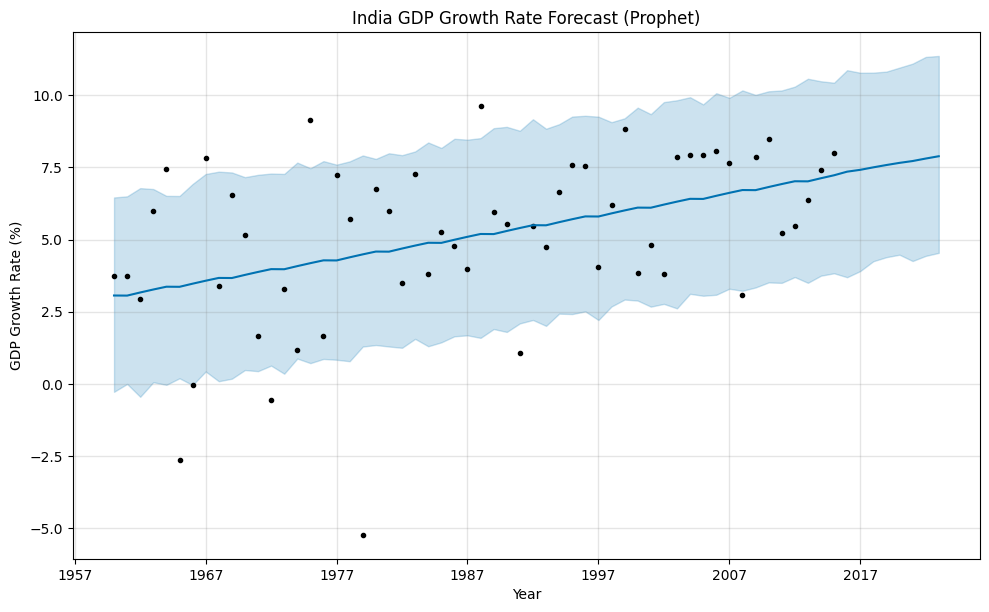


Evaluation for India:
RMSE: 5.02
MAE: 2.85


In [5]:
# Step 4: Forecast and Evaluate Example Country
example_country = "India"
model, forecast_df, full_years, rmse, mae = train_prophet(example_country, forecast_years=8, split_year=2015)

# Step 5: Plot the Forecast
fig = model.plot(forecast_df)
plt.title(f"{example_country} GDP Growth Rate Forecast (Prophet)")
plt.xlabel("Year")
plt.ylabel("GDP Growth Rate (%)")
plt.grid(True)
plt.show()

# Step 6: Print Evaluation Metrics
print(f"\nEvaluation for {example_country}:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

In [7]:
# Save evaluation metrics to file
import csv

results_path = "../data/model_results.csv"

# If file doesn't exist, create it and write header
if not os.path.exists(results_path):
    with open(results_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Model", "Country", "RMSE", "MAE"])  # header

# Append results
with open(results_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Prophet", example_country, rmse, mae])